In [ ]:
import numpy as np
import pandas as pd

In [2]:
train_fname = './dataset/IMDB Dataset.csv'
df_train = pd.read_csv(train_fname)
df_train.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
import matplotlib.pyplot as plt
df_train['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Text(0.5, 0, 'Sentiment')

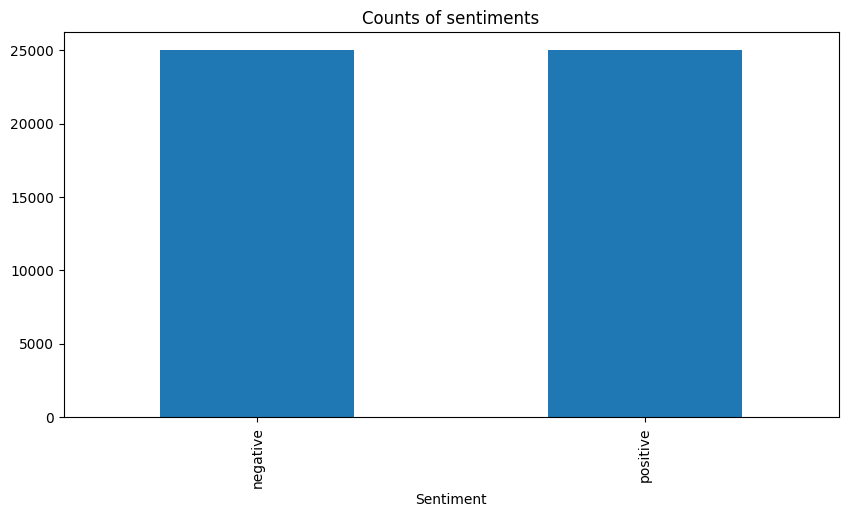

In [4]:
ax = df_train['sentiment'].value_counts().sort_index().plot(kind='bar', title='Counts of sentiments', figsize=(10, 5))
ax.set_xlabel('Sentiment')

In [5]:
import re
import nltk
import spacy
import spacy.cli

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [6]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

if not spacy.util.is_package("en_core_web_sm"):
    spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    words = word_tokenize(text)

    filtered_words = [word for word in words if not word in stop_words and len(word) > 3]
    lemmas = []
    for word in filtered_words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    sentence = ' '.join(lemmas)
    doc = nlp(sentence)
    lemmas = [token.lemma_ for token in doc]

    return lemmas

In [9]:
ex = df_train['review'].values[0]
print(ex)
print(clean_text(ex))

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

In [10]:
from tqdm import tqdm
tqdm.pandas()

df_train['words'] = df_train['review'].progress_apply(clean_text)

100%|██████████| 50000/50000 [19:10<00:00, 43.47it/s]


In [11]:
from collections import Counter

def get_corpus(df):
    corpus = []
    for i in tqdm(range(len(df))):
        corpus.append(df['words'].values[i])
    corpus = Counter(np.hstack(corpus))
    corpus2 = sorted(corpus, key=corpus.get, reverse=True)
    corpus2 = ['<PAK>', '<UNK>'] + corpus2
    vocab = {word: idx for idx, word in enumerate(corpus2, 1)}
    return corpus, vocab

In [12]:
corpus, vocab = get_corpus(df_train)

100%|██████████| 50000/50000 [00:00<00:00, 125718.66it/s]


In [13]:
def phrase_to_ints(words):
    ints = [vocab.get(word, vocab['<UNK>']) for word in words]
    return ints

In [14]:
phrase_to_ints(df_train['words'].values[0])

[959,
 288,
 11,
 150,
 1395,
 96,
 466,
 91,
 27,
 33,
 887,
 4131,
 11147,
 18,
 418,
 96,
 233,
 1190,
 17,
 4407,
 1997,
 8590,
 17,
 499,
 1456,
 931,
 513,
 418,
 2961,
 203,
 233,
 125,
 6118,
 29,
 10949,
 5197,
 2019,
 423,
 37071,
 473,
 1136,
 16270,
 362,
 3600,
 1684,
 919,
 1676,
 1574,
 739,
 165,
 18075,
 12255,
 146,
 3462,
 362,
 222,
 41,
 10562,
 8472,
 32043,
 10950,
 4132,
 786,
 1952,
 14857,
 186,
 62,
 5512,
 307,
 6410,
 6209,
 45,
 134,
 14,
 164,
 679,
 17,
 88,
 26,
 17,
 1316,
 330,
 89,
 220,
 884,
 1998,
 144,
 330,
 528,
 330,
 632,
 609,
 93,
 27,
 150,
 48,
 887,
 1249,
 1775,
 1261,
 11,
 559,
 846,
 7534,
 146,
 381,
 1125,
 418,
 418,
 4924,
 2668,
 1506,
 774,
 15270,
 4114,
 87,
 389,
 134,
 8,
 6358,
 484,
 472,
 4114,
 81,
 919,
 3631,
 242,
 536,
 1057,
 919,
 280,
 11,
 82,
 2980,
 2623,
 143,
 1274,
 939,
 372,
 304,
 290]

In [15]:
df_train['ints'] = df_train['words'].progress_apply(phrase_to_ints)

100%|██████████| 50000/50000 [00:01<00:00, 26171.76it/s]


In [16]:
review_to_ints = []
for i in tqdm(range(len(df_train))):
    review_to_ints.append(df_train['ints'].values[i])


100%|██████████| 50000/50000 [00:00<00:00, 123293.49it/s]


In [17]:
def pad_sequences(phrase_to_int, seq_length):
    if not isinstance(phrase_to_int[0], list):
        phrase_to_int = [phrase_to_int]
    pad_sequences = np.zeros((len(phrase_to_int), seq_length), dtype=int)
    for idx,row in tqdm(enumerate(phrase_to_int), total=len(phrase_to_int)):
        pad_sequences[idx, :len(row)] = np.array(row)[:seq_length]
    return pad_sequences

In [18]:
seq_length = 300
padded_sequences = pad_sequences(review_to_ints, seq_length)

100%|██████████| 50000/50000 [00:00<00:00, 74398.96it/s]


In [19]:
labels = df_train['sentiment'].tolist()
labels = [1 if label == "positive" else 0 for label in labels]

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [21]:
import torch

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_val_tensor = torch.tensor(X_test)
y_val_tensor = torch.tensor(y_test)

In [22]:
from torch.utils.data import DataLoader, TensorDataset

train_data = TensorDataset(X_train_tensor, y_train_tensor)
valid_data = TensorDataset(X_val_tensor, y_val_tensor)
batch_size = 50
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle = True)

In [23]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.__next__()

print('Sample input size: ', sample_x.size())
print('Sample label size: ', sample_y.size())
print('Sample input: \n', sample_x)

print("\nData loader size: {} (train), {} (val)".format(len(train_loader), len(valid_loader)))

Sample input size:  torch.Size([50, 300])
Sample label size:  torch.Size([50])
Sample input: 
 tensor([[  232,   171,   721,  ...,     0,     0,     0],
        [   41,    24,    22,  ...,     0,     0,     0],
        [   94,   165,  1106,  ...,     0,     0,     0],
        ...,
        [  194,     4,    74,  ...,     0,     0,     0],
        [10942,  1266,     3,  ...,     0,     0,     0],
        [    3,   679,   822,  ...,     0,     0,     0]])

Data loader size: 800 (train), 200 (val)


In [24]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [25]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)

        self.dropout = nn.Dropout(0.3)

        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)

        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        out = self.dropout(lstm_out)
        out = self.fc(out)

        sig_out = self.sig(out)

        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]

        return sig_out, hidden


    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))

        return hidden

In [26]:
n_vocab = len(vocab) + 1
n_embed = 400
n_hidden = 256
n_output = 1
n_layers = 2
learning_rate = 0.001

In [27]:
net = SentimentRNN(n_vocab, n_output, n_embed, n_hidden, n_layers)
print(net)

SentimentRNN(
  (embedding): Embedding(78704, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [28]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [1]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%d%m%y_%H%M%S")
model_name = "./dataset/model_{}.pth".format(current_time)
print(model_name)

./dataset/model_090424_191038.pth


In [30]:
n_epochs = 5
eval_every = 100
clip = 5
min_val_loss = float('inf')

train_losses = []
valid_losses = []

net.to(device)
net.train()

SentimentRNN(
  (embedding): Embedding(78704, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [31]:
for e in range(n_epochs):
    h = net.init_hidden(batch_size)
    
    counter = 0
    epoch_train_losses = []

    for inputs, labels in train_loader:
        counter += 1

        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])

        net.zero_grad()

        output, h = net(inputs, h)

        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
        
        train_loss = loss.item()
        epoch_train_losses.append(train_loss)

        if counter % eval_every == 0:
            val_h = net.init_hidden(batch_size)
            val_losses = []
            val_accuracies = []
            
            net.eval()
            
            for inputs, labels in valid_loader:
                val_h = tuple([each.data for each in val_h])
                inputs, labels = inputs.to(device), labels.to(device)

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            mean_val_loss = np.mean(val_losses)
            
            net.train()
            
            print("Epoch: {}/{},".format(e+1, n_epochs),
                  "Step: {},".format(counter),
                  "Loss: {:.6f},".format(loss.item()),
                  "Val loss: {:.6f}".format(mean_val_loss))

    valid_losses.append(mean_val_loss)
    print("Val loss after epoch {}: {:.6f}".format(e+1, mean_val_loss))
    
    epoch_train_loss = np.mean(epoch_train_losses)
    train_losses.append(epoch_train_loss)
    
    if mean_val_loss < min_val_loss:
        print("Validation loss decreased ({:.6f} --> {:.6f}). Saving model...".format(min_val_loss, mean_val_loss))
        min_val_loss = mean_val_loss
        torch.save(net.state_dict(), model_name)

Epoch: 1/5, Step: 100, Loss: 0.717290, Val loss: 0.695000
Epoch: 1/5, Step: 200, Loss: 0.700758, Val loss: 0.693200
Epoch: 1/5, Step: 300, Loss: 0.686254, Val loss: 0.694294
Epoch: 1/5, Step: 400, Loss: 0.691077, Val loss: 0.693044
Epoch: 1/5, Step: 500, Loss: 0.682890, Val loss: 0.694290
Epoch: 1/5, Step: 600, Loss: 0.690363, Val loss: 0.693210
Epoch: 1/5, Step: 700, Loss: 0.688911, Val loss: 0.692873
Epoch: 1/5, Step: 800, Loss: 0.685528, Val loss: 0.693016
Val loss after epoch 1: 0.693016
Validation loss decreased (inf --> 0.693016). Saving model...
Epoch: 2/5, Step: 100, Loss: 0.694124, Val loss: 0.694711
Epoch: 2/5, Step: 200, Loss: 0.684702, Val loss: 0.709446
Epoch: 2/5, Step: 300, Loss: 0.684846, Val loss: 0.695365
Epoch: 2/5, Step: 400, Loss: 0.684099, Val loss: 0.696009
Epoch: 2/5, Step: 500, Loss: 0.680435, Val loss: 0.695797
Epoch: 2/5, Step: 600, Loss: 0.666960, Val loss: 0.686774
Epoch: 2/5, Step: 700, Loss: 0.693710, Val loss: 0.693401
Epoch: 2/5, Step: 800, Loss: 0.7216

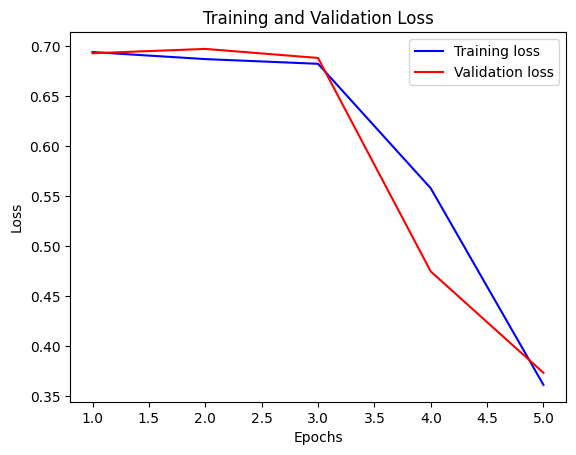

In [32]:
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, valid_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
def predict(net, sentence):
    words = clean_text(sentence)
    text_ints = phrase_to_ints(words)
    padded_text = pad_sequences(text_ints, seq_length)
    
    text_tensor = torch.from_numpy(padded_text)
    text_tensor = text_tensor.to(device)
    
    net.eval()
    
    batch_size = text_tensor.size(0)
    h = net.init_hidden(batch_size)
    
    output, h = net(text_tensor, h)
    pred = torch.round(output.squeeze())
    
    return output.item(), pred.item()

In [34]:
sentence = 'This movie is very awful!'
output, pred = predict(net, sentence)
print('Prediction value: {:.6f}'.format(output))
if(pred==1):
    print('Sentiment: positive')
else:
    print('Sentiment: negative')

100%|██████████| 1/1 [00:00<00:00, 8208.03it/s]

Prediction value: 0.078089
Sentiment: negative
